         Date   Open   High    Low  Close  Adj Close    Volume
0  2010-06-29  3.800  5.000  3.508  4.778      4.778  93831500
1  2010-06-30  5.158  6.084  4.660  4.766      4.766  85935500
2  2010-07-01  5.000  5.184  4.054  4.392      4.392  41094000
3  2010-07-02  4.600  4.620  3.742  3.840      3.840  25699000
4  2010-07-06  4.000  4.000  3.166  3.222      3.222  34334500
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3374e-04 - val_loss: 7.1833e-04
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8772e-06 - val_loss: 6.9263e-04
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8986e-06 - val_loss: 7.0748e-04
Epoch 4/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.4788e-06 - val_loss: 7.8971e-04
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1435e-06 - val_loss: 8.3856e-04
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.5284e-06 - val_loss: 8.1113e-04
Epoch 7/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.6362e-06 - val_loss: 9.3375e-04
Epoch 8/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.3639e-06 - val_loss: 8.6508e-04
Epoch 9/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8117e-06 - val_loss: 7.2636e-04
Epoch 10/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.0587e-06 - val_loss: 6.4532e-04
Epoch 11/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.1244e-0

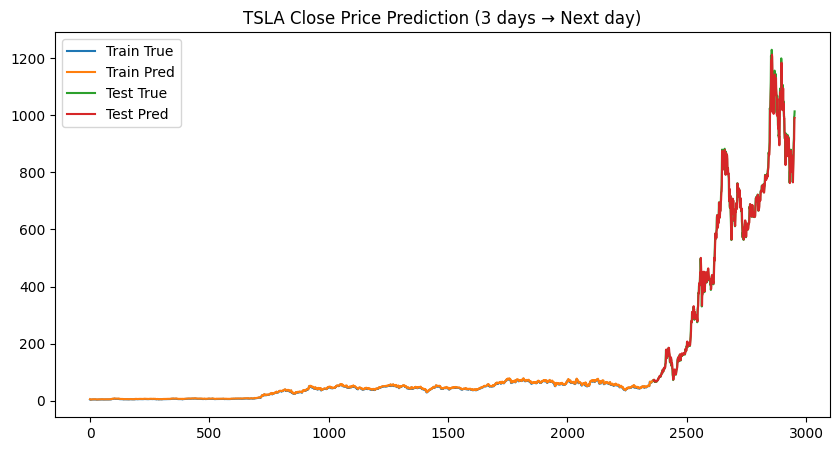

In [1]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1️⃣ 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TSLA.csv')
print(df.head())

# 2️⃣ 'Close' 열만 사용
data = df['Close'].values.reshape(-1,1)

# 3️⃣ 정규화
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# 4️⃣ 시퀀스 생성 함수 (3일 → 다음날)
window = 3
X, y = [], []
for i in range(len(data_scaled)-window):
    X.append(data_scaled[i:i+window])
    y.append(data_scaled[i+window])
X, y = np.array(X), np.array(y)

# 5️⃣ Train/Test 분리 (80:20)
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 6️⃣ LSTM 모델 구성
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(window,1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 7️⃣ 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=8,
                    validation_data=(X_test, y_test), verbose=1)

# 8️⃣ 예측
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# 9️⃣ 역정규화
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)

# 🔟 오차 계산
train_mse = mean_squared_error(y_train_inv, train_pred_inv)
test_mse  = mean_squared_error(y_test_inv, test_pred_inv)
train_mae = mean_absolute_error(y_train_inv, train_pred_inv)
test_mae  = mean_absolute_error(y_test_inv, test_pred_inv)

print(f"🔹 Train MSE: {train_mse:.4f}")
print(f"🔹 Test  MSE: {test_mse:.4f}")
print(f"🔹 Train MAE: {train_mae:.4f}")
print(f"🔹 Test  MAE: {test_mae:.4f}")

# 🔹 RMSE 계산 (해석 용이)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print(f"🔹 Train RMSE: {train_rmse:.4f}")
print(f"🔹 Test  RMSE: {test_rmse:.4f}")

# 🔹 시각화
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(y_train_inv)), y_train_inv, label='Train True')
plt.plot(np.arange(len(y_train_inv)), train_pred_inv, label='Train Pred')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_test_inv)), y_test_inv, label='Test True')
plt.plot(np.arange(len(y_train_inv), len(y_train_inv)+len(y_test_inv)), test_pred_inv, label='Test Pred')
plt.title('TSLA Close Price Prediction (3 days → Next day)')
plt.legend()
plt.show()
